In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(1,'/home/chocobo/Cenia-ODEPA/decode/')
sys.path.insert(1,'/home/chocobo/Cenia-ODEPA/')
sys.path

['/home/chocobo/Cenia-ODEPA/decode/examples',
 '/home/chocobo/Cenia-ODEPA/',
 '/home/chocobo/Cenia-ODEPA/decode/',
 '/home/chocobo/miniconda3/envs/fractal-resunet/lib/python310.zip',
 '/home/chocobo/miniconda3/envs/fractal-resunet/lib/python3.10',
 '/home/chocobo/miniconda3/envs/fractal-resunet/lib/python3.10/lib-dynload',
 '',
 '/home/chocobo/miniconda3/envs/fractal-resunet/lib/python3.10/site-packages']

In [3]:
!pwd

/home/chocobo/Cenia-ODEPA/decode/examples


In [4]:
import os
import time

import xarray as xr
from os.path import join, getsize
import numpy as np

import mxnet as mx
from mxnet import gluon

from mxnet import autograd
from multiprocessing import cpu_count
from FracTAL_ResUNet.nn.loss.mtsk_loss import *
from FracTAL_ResUNet.models.semanticsegmentation.FracTAL_ResUNet import *

from threading import Thread
import time
import rioxarray

# Test

In [81]:
# D6nf32 example 
depth=6
norm_type='GroupNorm'
norm_groups=4
ftdepth=5
NClasses=1
nfilters_init=32
psp_depth=4
nheads_start=4


net = FracTAL_ResUNet_cmtsk(nfilters_init=nfilters_init, NClasses=NClasses,depth=depth, ftdepth=ftdepth, psp_depth=psp_depth,norm_type=norm_type,norm_groups=norm_groups,nheads_start=nheads_start)
net.initialize()

depth:= 0, nfilters: 32, nheads::4, widths::1
depth:= 1, nfilters: 64, nheads::8, widths::1
depth:= 2, nfilters: 128, nheads::16, widths::1
depth:= 3, nfilters: 256, nheads::32, widths::1
depth:= 4, nfilters: 512, nheads::64, widths::1
depth:= 5, nfilters: 1024, nheads::128, widths::1
depth:= 6, nfilters: 512, nheads::128, widths::1
depth:= 7, nfilters: 256, nheads::64, widths::1
depth:= 8, nfilters: 128, nheads::32, widths::1
depth:= 9, nfilters: 64, nheads::16, widths::1
depth:= 10, nfilters: 32, nheads::8, widths::1


In [82]:
BatchSize = 6
img_size=256
NChannels = 4

input_img_1 = mx.random.uniform(shape=[BatchSize, NChannels, img_size, img_size])
input_img_2 = mx.random.uniform(shape=[BatchSize, NChannels, img_size, img_size])
input_img_1.shape

(6, 4, 256, 256)

In [134]:
# AT_6478_S2label_10m_256.tif
input_image = '~/datasets/AI4Boundaries2/sentinel2/images/AT/AT_6478_S2_10m_256.nc'
with xr.open_dataset(input_image) as ds:
    print(ds.keys())

KeysView(<xarray.Dataset>
Dimensions:      (time: 6, x: 256, y: 256)
Coordinates:
  * time         (time) datetime64[ns] 2019-03-01 2019-04-01 ... 2019-08-01
  * x            (x) float64 4.634e+06 4.634e+06 ... 4.637e+06 4.637e+06
  * y            (y) float64 2.762e+06 2.762e+06 ... 2.759e+06 2.759e+06
Data variables:
    B2           (time, y, x) float32 ...
    B3           (time, y, x) float32 ...
    B4           (time, y, x) float32 ...
    B8           (time, y, x) float32 ...
    NDVI         (time, y, x) float32 ...
    spatial_ref  int32 ...)


In [135]:
ds[['B2','B3','B4','B8']]

<xarray.Dataset>
Dimensions:  (time: 6, y: 256, x: 256)
Coordinates:
  * time     (time) datetime64[ns] 2019-03-01 2019-04-01 ... 2019-08-01
  * x        (x) float64 4.634e+06 4.634e+06 4.634e+06 ... 4.637e+06 4.637e+06
  * y        (y) float64 2.762e+06 2.762e+06 2.762e+06 ... 2.759e+06 2.759e+06
Data variables:
    B2       (time, y, x) float32 ...
    B3       (time, y, x) float32 ...
    B4       (time, y, x) float32 ...
    B8       (time, y, x) float32 ...

In [136]:
# Dims: bands, time, img height, img length
ds[['B2','B3','B4','B8']].to_array().to_numpy().shape

(4, 6, 256, 256)

In [137]:
img_np = ds[['B2','B3','B4','B8']].to_array().to_numpy()

In [138]:
img_np.shape

(4, 6, 256, 256)

In [139]:
type(img_np[0]), type(img_np[0][0]), type(img_np[0][0][0]), type(img_np[0][0][0][0])

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.float32)

In [140]:
imgs_np = [img_np[:, t , :, :] for t in range(img_np.shape[1]) ]

In [141]:
for i in imgs_np:
    print(i.shape)

(4, 256, 256)
(4, 256, 256)
(4, 256, 256)
(4, 256, 256)
(4, 256, 256)
(4, 256, 256)


In [142]:
img_ndarray = mx.nd.array(imgs_np)
img_ndarray.shape

(6, 4, 256, 256)

## Example of forward operation:


In [143]:
outs = net(img_ndarray)

In [ ]:
# outs is a list of outputs: segmentation, boundary, distance. 
# Each has shape BatchSize, NClasses, img_size, img_size
# for out in outs:
#     print(type(out), out.shape)
# type(outs), labels_np[0][1,:5,:5]

### Example of performing backward with multitasking operation

In [144]:
# (e) an extent mask, (f) a boundary mask, (g) a distance mask, and (h) a field enumeration
# label_path = '/home/chocobo/datasets/AI4Boundaries2/sentinel2/masks/AT/AT_10032_S2label_10m_256.tif'
# AT_6478_S2label_10m_256.tif
label_path = '/home/chocobo/datasets/AI4Boundaries2/sentinel2/masks/AT/AT_6478_S2label_10m_256.tif'
label_ds = rioxarray.open_rasterio(label_path)[:3]

# with xr.open_dataset(label_path) as label_ds:
#     print(label_ds.keys())
label_ds.shape

(3, 256, 256)

In [145]:
# The label is composed of four bands
# vector label, boundary mask, distance mask, and field enumeration
# (e) an extent mask, (f) a boundary mask, (g) a distance mask, and (h) a field enumeration
label_ds

<xarray.DataArray (band: 3, y: 256, x: 256)>
[196608 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 4.634e+06 4.634e+06 ... 4.637e+06 4.637e+06
  * y            (y) float64 2.762e+06 2.762e+06 ... 2.759e+06 2.759e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -10000.0
    scale_factor:   1.0
    add_offset:     0.0

[<Axes: > <Axes: > <Axes: >]


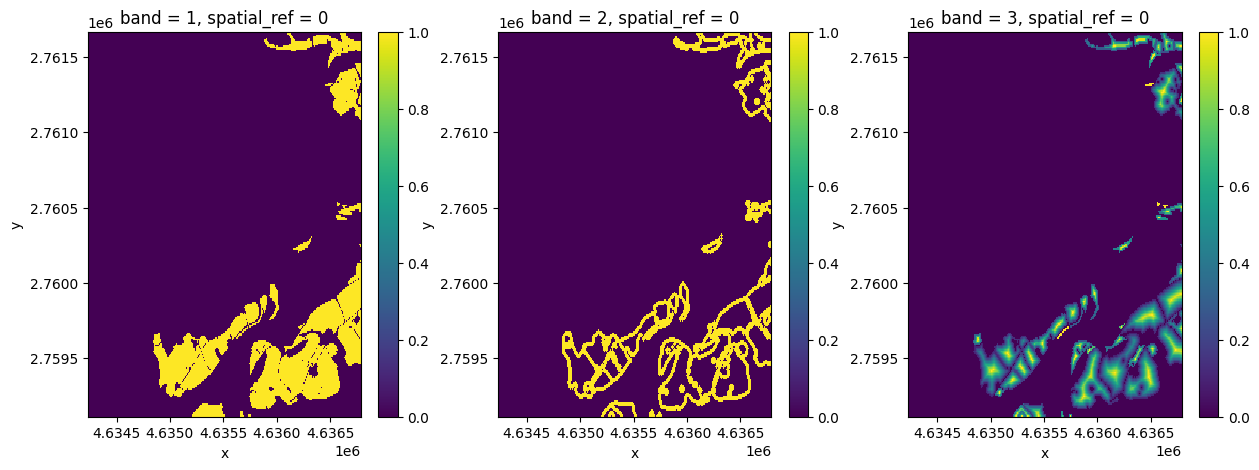

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# print(axes)
for i in range(label_ds.shape[0]):
    label_ds[i].plot(ax=axes[i])

In [147]:
label_np = np.array([[label_ds]]*BatchSize)
print(label_np.shape)
# label_ndarray = mx.nd.array(labels_np)
labels_np = [ mx.nd.array(label_np[:, :, t , :, :]) for t in range(label_np.shape[2]) ]
len(labels_np), labels_np[0].shape

(6, 1, 3, 256, 256)


(3, (6, 1, 256, 256))

In [148]:
print(BatchSize, NClasses, img_size, img_size)
labels_segm = mx.random.uniform(shape=[BatchSize, NClasses, img_size, img_size])
labels_segm = labels_segm > 0.5

labels_bound = mx.random.uniform(shape=[BatchSize, NClasses, img_size, img_size])
labels_bound = labels_bound > 0.5

labels_dist = mx.random.uniform(shape=[BatchSize, NClasses, img_size, img_size])

# print(labels_segm,labels_bound,labels_dist)
labels = [labels_segm,labels_bound,labels_dist]
# labels = mx.nd.concat(*labels,dim=1)
# labels.shape
len(labels), labels[0].shape

6 1 256 256


(3, (6, 1, 256, 256))

In [149]:
for l in labels_np:
    print(type(l), l.shape)

<class 'mxnet.ndarray.ndarray.NDArray'> (6, 1, 256, 256)
<class 'mxnet.ndarray.ndarray.NDArray'> (6, 1, 256, 256)
<class 'mxnet.ndarray.ndarray.NDArray'> (6, 1, 256, 256)


In [150]:
myMTSKL = mtsk_loss.mtsk_loss()

In [151]:
listOfPreds = net(img_ndarray)

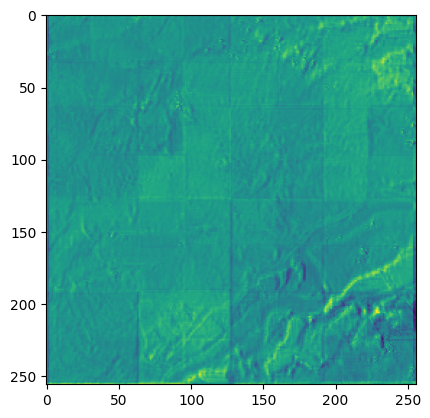

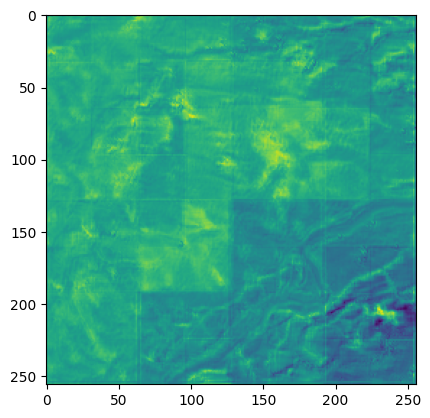

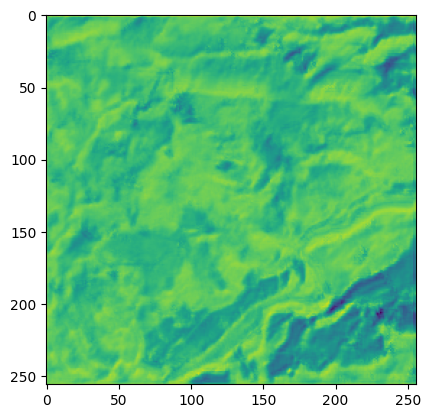

In [163]:
import mxnet as mx
import numpy as np
from matplotlib import pyplot as plt

for i in range(3):
    # print(listOfPreds[i][0][0].shape)
    img = listOfPreds[i][0][0].asnumpy() # convert to numpy array
    # img = img.transpose((1, 2, 0))  # Move channel to the last dimension
    # img = img.astype(np.uint)  # use uint8 (0-255)

    plt.imshow(img)
    plt.show()

In [ ]:
# outs is a list of outputs, segmentation, boundary, distance. 
# Each has shape BatchSize, NClasses, img_size, img_size
# BatchSize = 6

with autograd.record():
    # listOfPreds = net(input_img_1) # img_ndarray
    # print(len(img_ndarray))
    listOfPreds = net(img_ndarray)
    # print(type(listOfPreds[0]), type(label_ndarray))

    # print(len(listOfPreds), listOfPreds[0].shape, label_ndarray.shape)

    # pred_segm = labels_segm
    # pred_boun = listOfPreds[1] # Get boundaries
    # pred_dist = labels_dist

    # count = len(img_ndarray)
    

    # print(pred_segm.shape, pred_boun.shape, pred_dist.shape)
    # print(labels_segm.shape, labels_boun.shape, labels_dist.shape)

    # preds = (pred_segm, pred_boun, pred_dist)
    # labels = (labels_segm, labels_boun, labels_dist)

    # labels[0]

    loss = myMTSKL.loss(listOfPreds, labels_np)
    loss.backward()

<class 'list'> 3


In [ ]:
loss.shape

(6,)

In [ ]:
loss


[0.63697463 0.6363043  0.63518786 0.6368878  0.63702613 0.638539  ]
<NDArray 6 @cpu(0)>

# Train on AI4Boundaries

## Load data from Folder

In [5]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [6]:
def file_to_nparray(file_path, bands=['B2','B3','B4','B8']):
    # Open .nc or .tif file with XArray
    ds = xr.open_dataset(file_path)
    # Transform variables from selected bands to numpy
    np = ds[bands].to_array().to_numpy()
    # Reshape array
    imgs_np = [np[:, t , :, :] for t in range(np.shape[1])]
    return imgs_np
    

In [7]:
input_path = '~/datasets/AI4Boundaries2/sentinel2/images/AT/AT_10032_S2_10m_256.nc'
outs = file_to_nparray(input_path)
len(outs), outs[0].shape

(6, (4, 256, 256))

In [8]:
def label_to_nparray(label_path, img_count):
    # Open .nc or .tif file with XArray, filter bands
    ds = rioxarray.open_rasterio(label_path)[1:]
    # Transform variables from selected bands to numpy
    # ds = np.array([ds]*img_count)
    # labels_np = [ds[:, t , :, :] for t in range(ds.shape[1]) ]
    # label_ndarray = mx.nd.array(labels_np)

    label_np = np.array([[ds]]*img_count)
    # labels_np = [label_np[:, :, t , :, :] for t in range(label_np.shape[2])]
    labels_np = label_np.tolist()
    # Have one label for each image
    return labels_np

In [9]:
label_path = '/home/chocobo/datasets/AI4Boundaries2/sentinel2/masks/AT/AT_10032_S2label_10m_256.tif'
outs = label_to_nparray(label_path, 6)
len(outs), len(outs[0]), len(outs[0][0]), len(outs[0][0][0]), len(outs[0][0][0][0]) #, outs[0].shape

(6, 1, 3, 256, 256)

In [11]:
# label_path = '~/datasets/AI4Boundaries2/sentinel2/masks/AT/AT_10032_S2label_10m_256.tif'
# input_path = '~/datasets/AI4Boundaries2/sentinel2/images/AT/AT_10032_S2_10m_256.nc'
base_path = '/home/chocobo/datasets/AI4Boundaries2/sentinel2'
input_path = f'{base_path}/images'
label_path = f'{base_path}/masks'

In [21]:
input_list = []
label_list = []

for root, dirs, files in os.walk(input_path):
    l = len(files)
    if l:
        print(root, l)
        printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    # print(dirs)
    for i,file in enumerate(files):
        file_path = f'{root}/{file}'
        country = file.split('_')[0]
        number = file.split('_')[1]

        if country != 'LU':
            continue
        # print(file_path)
        # Build input file
        new_inputs = file_to_nparray(file_path)
        input_list = input_list + new_inputs
        # Get label file
        # print(file.split('_'))
        label_file_name = f'{country}_{number}_S2label_10m_256.tif'
        label_file_path = f'{label_path}/{country}/{label_file_name}'
        new_labels = label_to_nparray(label_file_path, len(new_inputs))
        label_list = label_list + new_labels
        # print(len(new_inputs),len(new_labels))
        # print(new_inputs.shape, new_labels.shape)

        if not os.path.isfile(label_file_path):
            print(f'Error: not found {label_file_path}')
        printProgressBar(i + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)


/home/chocobo/datasets/AI4Boundaries2/sentinel2/images/AT 2091
/home/chocobo/datasets/AI4Boundaries2/sentinel2/images/ES 652| 0.0% Complete
/home/chocobo/datasets/AI4Boundaries2/sentinel2/images/FR 2078 0.0% Complete
/home/chocobo/datasets/AI4Boundaries2/sentinel2/images/LU 132| 0.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
/home/chocobo/datasets/AI4Boundaries2/sentinel2/images/NL 1157
/home/chocobo/datasets/AI4Boundaries2/sentinel2/images/SE 1420 0.0% Complete
/home/chocobo/datasets/AI4Boundaries2/sentinel2/images/SI 301| 0.0% Complete


In [22]:
input_ndarray = mx.nd.array(input_list)

# Save dataset input images
mxnet_dataset_path = f'{base_path}/mxnet_dataset'
mx.nd.save(f'{mxnet_dataset_path}/LU_input_ndarray.mat', input_ndarray)

In [23]:
input_ndarray.shape

(792, 4, 256, 256)

In [24]:
label_ndarray = mx.nd.array(label_list)

In [25]:
label_ndarray.shape

(792, 1, 3, 256, 256)

In [26]:
mx.nd.save(f'{mxnet_dataset_path}/LU_label_ndarray.mat', label_ndarray)

## Build DataLoader

In [ ]:
# mxnet_dataset_path = f'{base_path}/mxnet_dataset'
# input_ndarray = mx.nd.array(mx.nd.load(f'{mxnet_dataset_path}/LU_input_ndarray.mat'))
# label_ndarray = mx.nd.array(mx.nd.load(f'{mxnet_dataset_path}/LU_label_ndarray.mat'))
# input_ndarray.shape, label_ndarray.shape

In [164]:
dataset = mx.gluon.data.dataset.ArrayDataset(input_ndarray, label_ndarray)

In [165]:
sample_idx = 4
sample = dataset[sample_idx]

print(len(sample), sample[0].shape, sample[1].shape)
# print(sample)

2 (4, 256, 256) (1, 3, 256, 256)


In [166]:
# data_loader = mx.gluon.data.DataLoader(dataset, batch_size=5, num_workers=CPU_COUNT)
batch_size = 6
train_data = gluon.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# valid_data = gluon.data.DataLoader(
#     dataset, batch_size=batch_size, num_workers=4)

In [167]:
for data, label in train_data:
    print(data.shape, label.shape)
    break
len(train_data)

(6, 4, 256, 256) (6, 1, 3, 256, 256)


132

## Train Model

In [168]:
# D6nf32 example 
nfilters_init=32
depth=6
psp_depth=4

ftdepth=5
norm_type='GroupNorm'
norm_groups=4
NClasses=1
nheads_start=4


net = FracTAL_ResUNet_cmtsk(
    nfilters_init=nfilters_init, NClasses=NClasses, depth=depth,
    ftdepth=ftdepth, psp_depth=psp_depth, norm_type=norm_type, 
    norm_groups=norm_groups, nheads_start=nheads_start)
net.initialize()

depth:= 0, nfilters: 32, nheads::4, widths::1
depth:= 1, nfilters: 64, nheads::8, widths::1
depth:= 2, nfilters: 128, nheads::16, widths::1
depth:= 3, nfilters: 256, nheads::32, widths::1
depth:= 4, nfilters: 512, nheads::64, widths::1
depth:= 5, nfilters: 1024, nheads::128, widths::1
depth:= 6, nfilters: 512, nheads::128, widths::1
depth:= 7, nfilters: 256, nheads::64, widths::1
depth:= 8, nfilters: 128, nheads::32, widths::1
depth:= 9, nfilters: 64, nheads::16, widths::1
depth:= 10, nfilters: 32, nheads::8, widths::1


In [169]:
net.initialize(init='Xavier', force_reinit=True)

In [170]:
optimizer = mx.optimizer.Adam()
trainer = gluon.Trainer(net.collect_params(), optimizer=optimizer)

In [ ]:
# with autograd.record():
#     listOfPreds = net(img_ndarray)
#     loss = myMTSKL.loss(listOfPreds, label_ndarray)
#     loss.backward()

In [171]:
import importlib
from FracTAL_ResUNet.nn.loss import mtsk_loss 

# make changes to example.py file

importlib.reload(FracTAL_ResUNet.nn.loss.mtsk_loss)
myMTSKL = mtsk_loss.mtsk_loss()

In [172]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = 0.
    tic = time.time()
    i = 0
    l = len(train_data)
    # printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            # Transform label to correct shape
            t_labels = [label[:, :, t , :, :] for t in range(label.shape[2])]
            # print(len(t_labels), t_labels[0].shape, len(output), output[0].shape)
            # print(output[0].ctx, t_labels[0].ctx)
            loss = myMTSKL.loss(output, t_labels)
            # print(loss)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training loss
        train_loss += loss.mean().asscalar()
        # printProgressBar(i + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        print(i, loss)
        i += 1
    print("Epoch %d: loss %.3f, in %.1f sec" % (
            epoch, train_loss/len(train_data), time.time()-tic))

0 
[0.6463108  0.6645795  0.63510656 0.6535847  0.6789379  0.6785629 ]
<NDArray 6 @cpu(0)>
1 
[0.62344533 0.6116767  0.635848   0.61787534 0.6337543  0.63160706]
<NDArray 6 @cpu(0)>
2 
[0.66860676 0.6037577  0.6250286  0.6384627  0.663791   0.6361618 ]
<NDArray 6 @cpu(0)>
3 
[0.6311836  0.61984736 0.6041512  0.62770873 0.5960078  0.61082196]
<NDArray 6 @cpu(0)>
4 
[0.61718965 0.60331386 0.59882987 0.60308176 0.59681344 0.63921756]
<NDArray 6 @cpu(0)>
5 
[0.61073023 0.6137552  0.6314474  0.61957026 0.60159993 0.6957368 ]
<NDArray 6 @cpu(0)>
6 
[0.6052302  0.61687464 0.6134972  0.5992954  0.60741454 0.61024565]
<NDArray 6 @cpu(0)>
7 
[0.63337755 0.5954123  0.5976203  0.5796695  0.587331   0.6230975 ]
<NDArray 6 @cpu(0)>
8 
[0.57096606 0.62016517 0.625205   0.5746365  0.5801873  0.59536916]
<NDArray 6 @cpu(0)>
9 
[0.5828667  0.61272866 0.596196   0.59402674 0.61690503 0.64819074]
<NDArray 6 @cpu(0)>
10 
[0.60976654 0.5774282  0.58000267 0.5705324  0.5660519  0.67960817]
<NDArray 6 @cpu(0)

In [62]:
train_loss/len(train_data)

0.5643038189772404

## GPU

In [78]:
from mxnet import nd, gpu, gluon, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import time

In [80]:
x = nd.ones((3,4), ctx=gpu(2))
x

[12:36:38] ../src/imperative/./imperative_utils.h:93: GPU support is disabled. Compile MXNet with USE_CUDA=1 to enable GPU support.


MXNetError: Traceback (most recent call last):
  File "../src/imperative/imperative.cc", line 81
MXNetError: Operator _ones is not implemented for GPU.